# **VGG16** **Model**

Load CIFAR data set

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

/Users/test/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## Identify Classnames, plot and show images from dataset


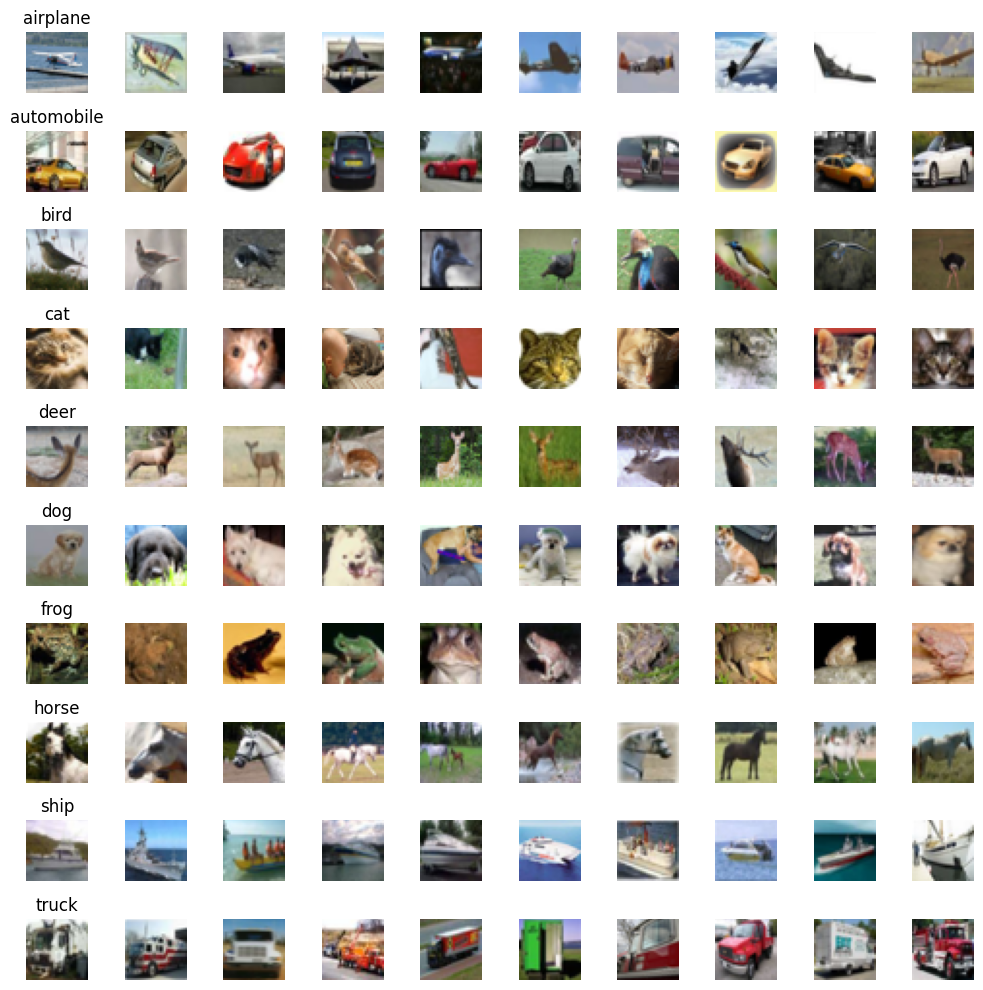

In [3]:
# CIFAR-10 class names
class_names = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

# Create a 10x10 plot (10 images from each of the 10 classes)
plt.figure(figsize=(10, 10))
for class_idx in range(10):
    # Find indexes of all images of current class
    idxs = np.where(y_train.flatten() == class_idx)[0]
    # Select 10 random images
    selected = np.random.choice(idxs, 10, replace=False)
    for i, img_idx in enumerate(selected):
        plt.subplot(10, 10, class_idx * 10 + i + 1)
        plt.imshow(x_train[img_idx])
        plt.axis('off')
        if i == 0:
            plt.title(class_names[class_idx])
plt.tight_layout()
plt.show()

### Convert classes to one-hot encoding


In [4]:
# Convert classes to one-hot encoding
y_train_onehot = to_categorical(y_train, num_classes=10)
y_test_onehot = to_categorical(y_test, num_classes=10)

print(y_train_onehot.shape)
print(y_test_onehot.shape)

(50000, 10)
(10000, 10)


### Normalize the images


In [5]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

print(x_train.shape)
print(x_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


### VGG16 Model with several layers

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input

# Load VGG16 base model (modify input shape for CIFAR-10)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

layered_model = Sequential()
layered_model.add(base_model)
layered_model.add(Flatten())
layered_model.add(Dense(256, activation='relu'))
layered_model.add(Dropout(0.3))
layered_model.add(Dense(128, activation='relu'))
layered_model.add(Dropout(0.3))
layered_model.add(Dense(10, activation='softmax'))


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 1, 1, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,880,202 (56.76 MB)

 Trainable params: 7,244,938 (27.64 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

### Adds Freezing Layers

In [ ]:
# Freeze some VGG16 layers to prevent overfitting
for layer in base_model.layers[:15]:  # Freeze earlier layers (e.g., first 15)
    layer.trainable = False


layered_model.summary()


### Compiles Model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#compile model
layered_model.compile(optimizer=Adam(learning_rate=3e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Reduce learning rate and apply early stopping and data augmentation

In [ ]:


#reduce the learning rate when validation loss plateaus, ensuring fine-tuning in later stages:
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

#use early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

#artificially increase the diversity of training data with data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,           # Random rotations up to 15 degrees
    width_shift_range=0.1,       # Horizontal shifts
    height_shift_range=0.1,      # Vertical shifts
    horizontal_flip=True,        # Randomly flip images horizontally
    zoom_range=0.1,              # Random zoom
    shear_range=0.1,             # Shear transformations
    fill_mode='nearest'          # Fill pixels with nearest value
)



NameError: name 'layered_model' is not defined

### Fit data

In [ ]:
# Fit the data generator on training data
datagen.fit(x_train)

history = layered_model.fit(
    x_train, y_train_onehot,
    epochs=50,
    batch_size=64,
    validation_data=(x_test, y_test_onehot),
    callbacks=[lr_scheduler],
    verbose=2
)

# Evaluate the model on the test set after training
loss, accuracy = layered_model.evaluate(x_test, y_test_onehot, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

layered_model.summary()

### Plot to visualize training history

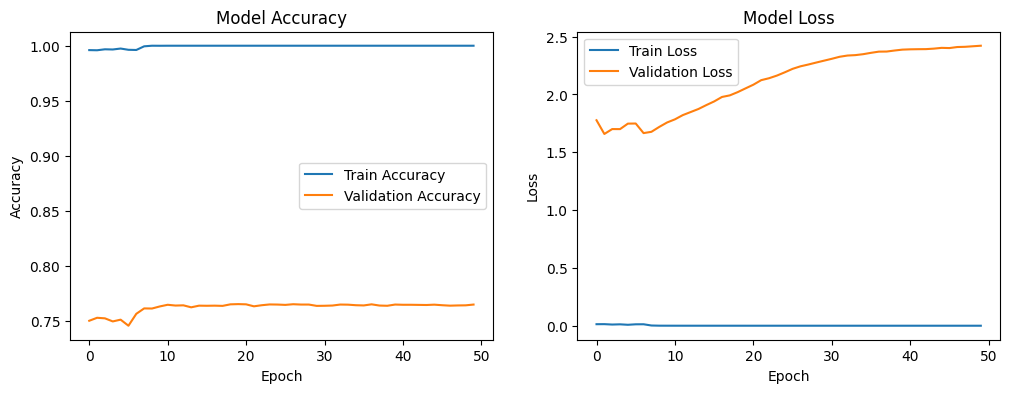

In [30]:
import matplotlib.pyplot as plt

# Plot accuracy and loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
layered_model.save("layered_model.keras")

## Simple Model

In [19]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense


simple_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(100, activation='relu'),
    Dense(10, activation='softmax')
])


# reduces learning rate of compile model
simple_model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#reduce the learning rate when validation loss plateaus, ensuring fine-tuning in later stages:
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

#use early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

simple_model.summary()


datagen = ImageDataGenerator(
    rotation_range=15,           # Random rotations up to 15 degrees
    width_shift_range=0.1,       # Horizontal shifts
    height_shift_range=0.1,      # Vertical shifts
    horizontal_flip=True,        # Randomly flip images horizontally
    zoom_range=0.1,              # Random zoom
    shear_range=0.1,             # Shear transformations
    fill_mode='nearest'          # Fill pixels with nearest value
)

# Fit the data generator on training data
datagen.fit(x_train)

history = simple_model.fit(
    x_train, y_train_onehot,
    epochs=50,
    batch_size=64,
    validation_data=(x_test, y_test_onehot),
    callbacks=[lr_scheduler],
    verbose=2
)

# Evaluate the model on the test set after training
loss, accuracy = simple_model.evaluate(x_test, y_test_onehot, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
simple_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 7200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 100)            │       720,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 722,006 (2.75 MB)

 Trainable params: 722,006 (2.75 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
782/782 - 7s - 9ms/step - accuracy: 0.3781 - loss: 1.7714 - val_accuracy: 0.4519 - val_loss: 1.5647 - learning_rate: 1.0000e-04
Epoch 2/50
782/782 - 3s - 3ms/step - accuracy: 0.4835 - loss: 1.4819 - val_accuracy: 0.4993 - val_loss: 1.4153 - learning_rate: 1.0000e-04
Epoch 3/50
782/782 - 5s - 7ms/step - accuracy: 0.5284 - loss: 1.3595 - val_accuracy: 0.5340 - val_loss: 1.3313 - learning_rate: 1.0000e-04
Epoch 4/50
782/782 - 5s - 6ms/step - accuracy: 0.5527 - loss: 1.2859 - val_accuracy: 0.5519 - val_loss: 1.2827 - learning_rate: 1.0000e-04
Epoch 5/50
782/782 - 3s - 4ms/step - accuracy: 0.5704 - loss: 1.2380 - val_accuracy: 0.5622 - val_loss: 1.2495 - learning_rate: 1.0000e-04
Epoch 6/50
782/782 - 3s - 3ms/step - accuracy: 0.5863 - loss: 1.1953 - val_accuracy: 0.5691 - val_loss: 1.2207 - learning_rate: 1.0000e-04
Epoch 7/50
782/782 - 3s - 4ms/step - accuracy: 0.5983 - loss: 1.1610 - val_accuracy: 0.5810 - val_loss: 1.1975 - learning_rate: 1.0000e-04
Epoch 8/50
782/782 - 3s - 4

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 7200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 100)            │       720,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,166,020 (8.26 MB)

 Trainable params: 722,006 (2.75 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,444,014 (5.51 MB)

### Plots visualization of the data

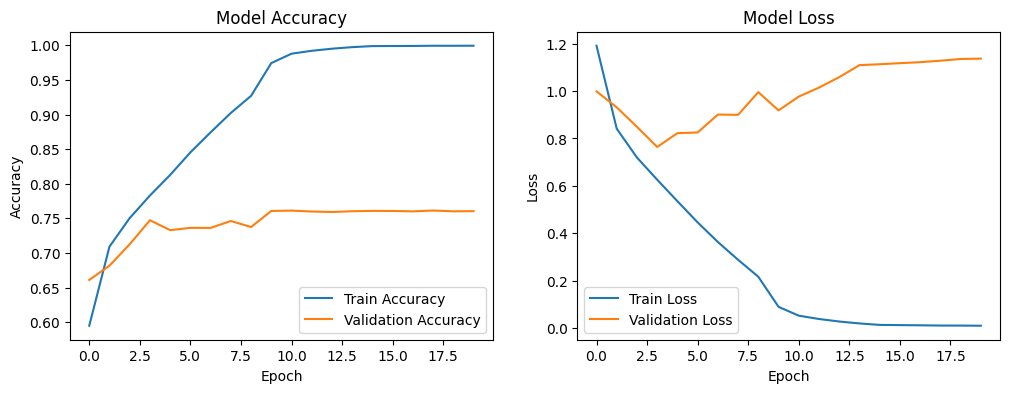

In [49]:
import matplotlib.pyplot as plt

# Plot accuracy and loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [1]:
simple_model.save("simple_model.keras")

NameError: name 'simple_model' is not defined

In [50]:
# Evaluate the trained model on a separate validation set.

# Load CIFAR-10 dataset to create a validation set
# Assuming x_train, y_train, x_test, y_test are already loaded from previous code
# Split the original test set into a validation set and a new test set
from sklearn.model_selection import train_test_split

# Assuming x_test and y_test are the original test sets
x_val, x_test_new, y_val, y_test_new = train_test_split(x_test, y_test_onehot, test_size=0.5, random_state=42)

print(f"Original test set shape: {x_test.shape}")
print(f"New test set shape: {x_test_new.shape}")
print(f"Validation set shape: {x_val.shape}")

# Now evaluate the trained model on the validation set
loss_val, accuracy_val = simple_model.evaluate(x_val, y_val, verbose=0)
print(f"Validation Loss: {loss_val:.4f}")
print(f"Validation Accuracy: {accuracy_val:.4f}")

# You can also evaluate on the new test set to see performance on unseen data
loss_test_new, accuracy_test_new = simple_model.evaluate(x_test_new, y_test_new, verbose=0)
print(f"New Test Loss: {loss_test_new:.4f}")
print(f"New Test Accuracy: {accuracy_test_new:.4f}")

Original test set shape: (10000, 32, 32, 3)
New test set shape: (5000, 32, 32, 3)
Validation set shape: (5000, 32, 32, 3)
Validation Loss: 0.9713
Validation Accuracy: 0.6658
New Test Loss: 0.9714
New Test Accuracy: 0.6674


In [51]:
# Compute and report metrics

from sklearn.metrics import classification_report

# Get predictions for the test set
y_pred = simple_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_onehot, axis=1)

# Compute and print classification report
print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Classification Report:
              precision    recall  f1-score   support

    airplane       0.71      0.71      0.71      1000
  automobile       0.80      0.74      0.77      1000
        bird       0.51      0.54      0.52      1000
         cat       0.50      0.49      0.50      1000
        deer       0.61      0.61      0.61      1000
         dog       0.59      0.56      0.58      1000
        frog       0.72      0.78      0.75      1000
       horse       0.74      0.72      0.73      1000
        ship       0.78      0.77      0.77      1000
       truck       0.72      0.75      0.73      1000

    accuracy                           0.67     10000
   macro avg       0.67      0.67      0.67     10000
weighted avg       0.67      0.67      0.67     10000



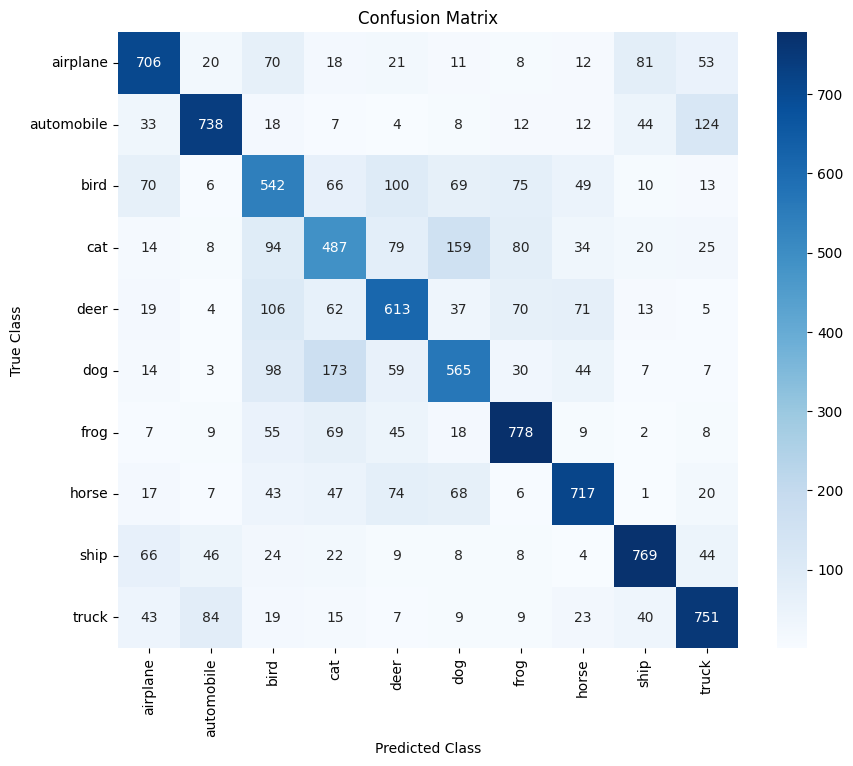

In [52]:
# Visualize the confusion matrix to understand model performance across different classes.

from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Visualize the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.show()

## Batch Normalization Model



In [8]:
# Define model

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import BatchNormalization



#Batch normalization only normalizes the input data. As data passes through the network’s layers (convolutional and dense), activations can still shift in scale and distribution due to weight updates, a phenomenon called internal covariate shift.
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))


batch_norm_model = Sequential()
batch_norm_model.add(base_model)
batch_norm_model.add(Flatten())
batch_norm_model.add(Dense(256, activation='relu'))
batch_norm_model.add(BatchNormalization())
batch_norm_model.add(Dropout(0.3))
batch_norm_model.add(Dense(128, activation='relu'))
batch_norm_model.add(BatchNormalization())
batch_norm_model.add(Dense(10, activation='softmax'))

In [ ]:
# Freeze some VGG layers
for layer in base_model.layers[:15]:
    layer.trainable = False

# Compile after building the model
batch_norm_model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

# Fit the model
history = batch_norm_model.fit(
    x_train, y_train_onehot,
    epochs=20,
    batch_size=64,
    validation_data=(x_test, y_test_onehot),
    callbacks=[lr_scheduler],
    verbose=2
)

batch_norm_model.summary()

Epoch 1/20
782/782 - 25s - 32ms/step - accuracy: 0.5949 - loss: 1.1918 - val_accuracy: 0.6611 - val_loss: 0.9990 - learning_rate: 1.0000e-04
Epoch 2/20
782/782 - 15s - 19ms/step - accuracy: 0.7092 - loss: 0.8412 - val_accuracy: 0.6817 - val_loss: 0.9315 - learning_rate: 1.0000e-04
Epoch 3/20
782/782 - 21s - 27ms/step - accuracy: 0.7504 - loss: 0.7195 - val_accuracy: 0.7126 - val_loss: 0.8492 - learning_rate: 1.0000e-04
Epoch 4/20
782/782 - 15s - 19ms/step - accuracy: 0.7830 - loss: 0.6259 - val_accuracy: 0.7473 - val_loss: 0.7644 - learning_rate: 1.0000e-04
Epoch 5/20
782/782 - 21s - 27ms/step - accuracy: 0.8127 - loss: 0.5352 - val_accuracy: 0.7330 - val_loss: 0.8226 - learning_rate: 1.0000e-04
Epoch 6/20
782/782 - 20s - 25ms/step - accuracy: 0.8453 - loss: 0.4457 - val_accuracy: 0.7363 - val_loss: 0.8255 - learning_rate: 1.0000e-04
Epoch 7/20
782/782 - 16s - 20ms/step - accuracy: 0.8742 - loss: 0.3629 - val_accuracy: 0.7362 - val_loss: 0.9010 - learning_rate: 1.0000e-04
Epoch 8/20
78

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 1, 1, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,373,152 (112.05 MB)

 Trainable params: 7,245,706 (27.64 MB)

 Non-trainable params: 7,636,032 (29.13 MB)

 Optimizer params: 14,491,414 (55.28 MB)

In [9]:
batch_norm_model.save("batch_norm_model.keras")

### Measure loss and test accuracy

In [40]:
# Evaluate the model on the test set after training
loss, accuracy = batch_norm_model.evaluate(x_test, y_test_onehot, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Test Loss: 1.1373
Test Accuracy: 0.7604


### Plots visualization

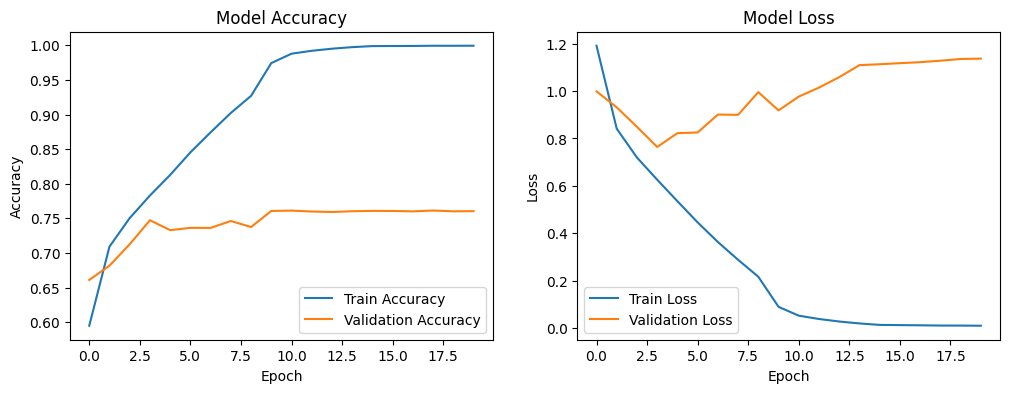

In [41]:
import matplotlib.pyplot as plt

# Plot accuracy and loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [42]:
from sklearn.model_selection import train_test_split

# Assuming x_test and y_test are the original test sets
x_val, x_test_new, y_val, y_test_new = train_test_split(x_test, y_test_onehot, test_size=0.5, random_state=42)

print(f"Original test set shape: {x_test.shape}")
print(f"New test set shape: {x_test_new.shape}")
print(f"Validation set shape: {x_val.shape}")

# Now evaluate the trained model on the validation set
loss_val, accuracy_val = batch_norm_model.evaluate(x_val, y_val, verbose=0)
print(f"Validation Loss: {loss_val:.4f}")
print(f"Validation Accuracy: {accuracy_val:.4f}")

# You can also evaluate on the new test set to see performance on unseen data
loss_test_new, accuracy_test_new = batch_norm_model.evaluate(x_test_new, y_test_new, verbose=0)
print(f"New Test Loss: {loss_test_new:.4f}")
print(f"New Test Accuracy: {accuracy_test_new:.4f}")

Original test set shape: (10000, 32, 32, 3)
New test set shape: (5000, 32, 32, 3)
Validation set shape: (5000, 32, 32, 3)
Validation Loss: 1.1679
Validation Accuracy: 0.7528
New Test Loss: 1.1068
New Test Accuracy: 0.7680


### Creates predictions

In [43]:
# Compute and report metrics

from sklearn.metrics import classification_report

# Get predictions for the test set
y_pred = batch_norm_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_onehot, axis=1)

# Compute and print classification report
print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step

Classification Report:
              precision    recall  f1-score   support

    airplane       0.81      0.83      0.82      1000
  automobile       0.85      0.86      0.86      1000
        bird       0.72      0.70      0.71      1000
         cat       0.56      0.58      0.57      1000
        deer       0.71      0.70      0.71      1000
         dog       0.65      0.64      0.65      1000
        frog       0.79      0.81      0.80      1000
       horse       0.82      0.82      0.82      1000
        ship       0.87      0.86      0.86      1000
       truck       0.82      0.81      0.81      1000

    accuracy                           0.76     10000
   macro avg       0.76      0.76      0.76     10000
weighted avg       0.76      0.76      0.76     10000



### Plots confusion matrix

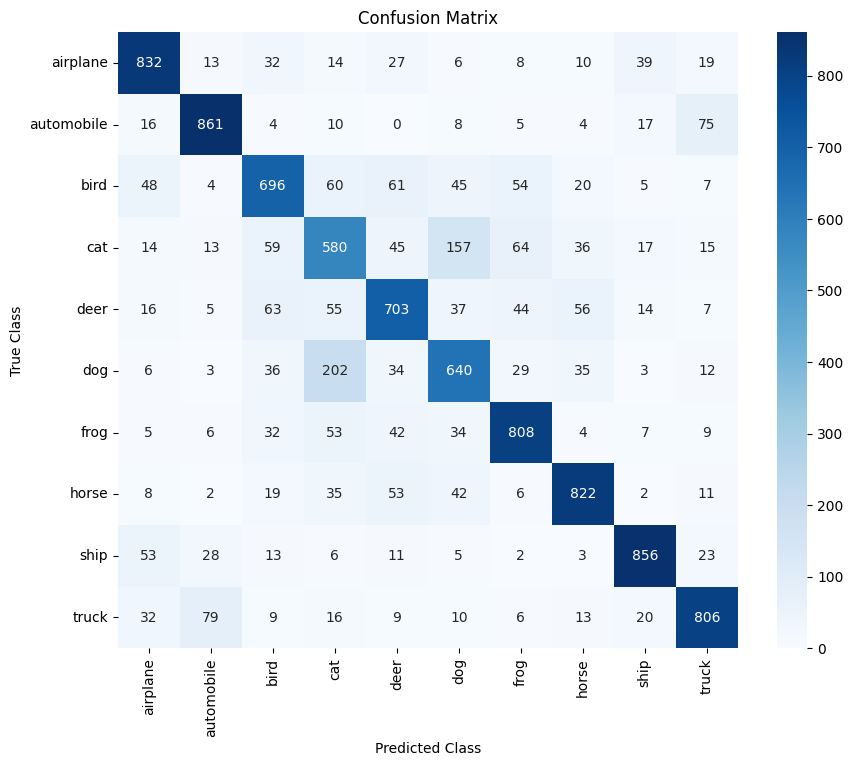

In [44]:
# Visualize the confusion matrix to understand model performance across different classes.

from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Visualize the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.show()